# Build Clotho Development Parquet

This notebook converts the **Clotho v2.x development split** that you downloaded
from Zenodo into a single **Parquet** file with:

- `audio`: a Hugging Face `Audio` column (waveform + sampling rate)
- `caption`: one caption per row
- `file_name`: original audio file name
- `caption_idx`: which caption (1–5)
- `split`: `"development"`

Edit the paths in the config cell below if needed, then run all cells.


In [1]:
from pathlib import Path

import pandas as pd
import soundfile as sf
import torch
from tqdm import tqdm

In [2]:

# ------------------------------------------------------------------
# Configuration
# ------------------------------------------------------------------
# Adjust these paths to match your repo layout.

# Directory that contains the *audio files* for the development split.
# From your screenshot, this is likely: v2_code_base/data/clotho/development
from pathlib import Path


CLOTHO_TRAIN_AUDIO_DIR = Path.cwd() / "data" / "clotho" / "development"
CLOTHO_VAL_AUDIO_DIR = Path.cwd() / "data" / "clotho" / "validation"
CLOTHO_TEST_AUDIO_DIR = Path.cwd() / "data" / "clotho" / "evaluation"

# Path to the *captions CSV* for development.
# From your screenshot, this looked like: v2_code_base/data/clotho_captions_development.csv
CLOTHO_TRAIN_CAPTIONS_CSV = Path.cwd() / "data" / "clotho_captions_development.csv"
CLOTHO_VAL_CAPTIONS_CSV = Path.cwd() / "data" / "clotho_captions_validation.csv"
CLOTHO_TEST_CAPTIONS_CSV = Path.cwd() / "data" / "clotho_captions_evaluation.csv"


# Output Parquet path (will be created if missing)
OUTPUT_DEV_MAIN_ROOT = Path.cwd() / "data" / "final_dataset" / "clotho"
OUTPUT_DEV_MAIN_ROOT.mkdir(parents=True, exist_ok=True)

OUTPUT_TRAIN_PARQUET_PATH = OUTPUT_DEV_MAIN_ROOT / "clotho_train.parquet"
OUTPUT_VAL_PARQUET_PATH = OUTPUT_DEV_MAIN_ROOT / "clotho_val.parquet"
OUTPUT_TEST_PARQUET_PATH = OUTPUT_DEV_MAIN_ROOT / "clotho_test.parquet"

# Clotho audio sampling rate (per paper: 44.1 kHz)
TARGET_SR = 44_100

print("Audio dir :", CLOTHO_TRAIN_AUDIO_DIR.resolve())
print("Captions  :", CLOTHO_TRAIN_CAPTIONS_CSV.resolve())
print("Output    :", OUTPUT_TRAIN_PARQUET_PATH.resolve())

Audio dir : /storage/ice1/1/0/vchopra37/projects/edge_glass/code_base/v2_code_base/data/clotho/development
Captions  : /storage/ice1/1/0/vchopra37/projects/edge_glass/code_base/v2_code_base/data/clotho_captions_development.csv
Output    : /storage/ice1/1/0/vchopra37/projects/edge_glass/code_base/v2_code_base/data/final_dataset/clotho/clotho_train.parquet


In [3]:
# -------------------------------------------------------
# BUILD RECORDS: ONE ENTRY PER AUDIO FILE
# -------------------------------------------------------
from pathlib import Path

def build_waveform_record(CLOTHO_DEV_AUDIO_DIR:Path, CLOTHO_DEV_CAPTIONS_CSV:Path, OUTPUT_PARQUET_PATH:Path):
    
    # -------------------------------------------------------
    # LOAD CSV
    # -------------------------------------------------------
    df = pd.read_csv(CLOTHO_DEV_CAPTIONS_CSV)

    if "file_name" not in df.columns:
        raise ValueError(f"'file_name' column not found in CSV. Columns: {df.columns.tolist()}")

    caption_cols = [c for c in df.columns if c.lower().startswith("caption")]
    if not caption_cols:
        raise ValueError(f"No caption columns found in CSV. Columns: {df.columns.tolist()}")

    print("Caption columns:", caption_cols)
    print(f"Total unique audio files in CSV: {df['file_name'].nunique():,}")


    records = []
    missing_audio = 0

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Building records"):
        file_name = str(row["file_name"])
        audio_path = CLOTHO_DEV_AUDIO_DIR / file_name

        if not audio_path.exists():
            missing_audio += 1
            continue

        # Load waveform from disk
        # always_2d=False -> shape (num_samples,) for mono, (num_samples, channels) for stereo
        waveform, sr = sf.read(str(audio_path), always_2d=False)

        # Convert stereo -> mono by averaging channels
        if waveform.ndim == 2:
            waveform = waveform.mean(axis=1)

        # Convert to float32 torch tensor
        waveform = torch.from_numpy(waveform.astype("float32"))

        # Collect all non-empty captions for this file
        captions = []
        for col in caption_cols:
            val = row[col]
            if isinstance(val, str) and val.strip():
                captions.append(val.strip())

        if not captions:
            # No valid captions, skip this file
            continue

        records.append(
            {
                "file_name": file_name,
                "sr": int(sr),
                "waveform": waveform,
                "captions": captions,  # list[str]
            }
        )

    print(f"\nKept {len(records):,} audio files.")
    print(f"Missing audio files (not found on disk): {missing_audio:,}")

    # -------------------------------------------------------
    # SAVE TO ONE TRAINING FILE
    # -------------------------------------------------------
    print(f"\n💾 Saving training data to: {OUTPUT_PARQUET_PATH}")
    torch.save(records, OUTPUT_PARQUET_PATH)
    print("✅ Done.")


In [4]:
# build_waveform_record(CLOTHO_TRAIN_AUDIO_DIR, CLOTHO_TRAIN_CAPTIONS_CSV, OUTPUT_TRAIN_PARQUET_PATH)

In [5]:
# build_waveform_record(CLOTHO_VAL_AUDIO_DIR, CLOTHO_VAL_CAPTIONS_CSV, OUTPUT_VAL_PARQUET_PATH)

In [6]:
build_waveform_record(CLOTHO_TEST_AUDIO_DIR, CLOTHO_TEST_CAPTIONS_CSV, OUTPUT_TEST_PARQUET_PATH)

Caption columns: ['caption_1', 'caption_2', 'caption_3', 'caption_4', 'caption_5']
Total unique audio files in CSV: 1,045


Building records: 100%|██████████| 1045/1045 [00:42<00:00, 24.50it/s]



Kept 1,045 audio files.
Missing audio files (not found on disk): 0

💾 Saving training data to: /storage/ice1/1/0/vchopra37/projects/edge_glass/code_base/v2_code_base/data/final_dataset/clotho/clotho_test.parquet
✅ Done.


### Optional Test

In [7]:
import torch

records = torch.load(OUTPUT_TRAIN_PARQUET_PATH)
print(len(records), "audio items")

3839 audio items


In [8]:
ex = records[0]
print("File Name:",ex["file_name"])
print("Sample Rate:", ex["sr"])
print("Waveform Shape:", ex["waveform"].shape)     # torch.FloatTensor
print("Captions:", ex["captions"])           # list of strings

# in a Dataset:
# - you can pick a random caption per audio each epoch
# - or flatten (audio, caption) pairs once at Dataset init


File Name: Distorted AM Radio noise.wav
Sample Rate: 44100
Waveform Shape: torch.Size([1153825])
Captions: ['A muddled noise of broken channel of the TV', 'A television blares the rhythm of a static TV.', 'Loud television static dips in and out of focus', 'The loud buzz of static constantly changes pitch and volume.', 'heavy static and the beginnings of a signal on a transistor radio']


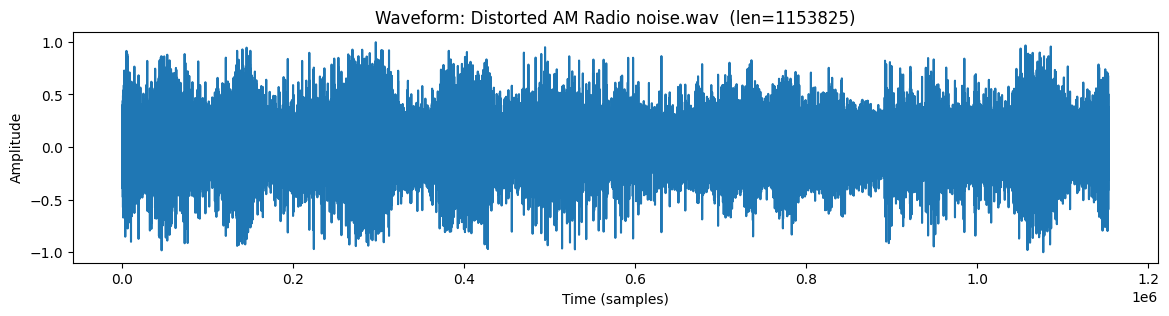

In [9]:
import matplotlib.pyplot as plt

waveform = ex["waveform"].numpy()
sr = ex["sr"]

plt.figure(figsize=(14, 3))
plt.plot(waveform)
plt.title(f"Waveform: {ex['file_name']}  (len={len(waveform)})")
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.show()


In [10]:
import IPython.display as ipd

ipd.Audio(ex["waveform"].numpy(), rate=ex["sr"])
